In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

from util import cmapss
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import r2_score

# Load data
data_folder = '/app/data'
data = cmapss.load_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1])

# Focus on a subset of the data
data_by_src = cmapss.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

tr, ts = cmapss.partition_by_machine(dt, tr_mcn)

# Standardization and normalization
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

trmaxrul = tr['rul'].max()
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

# Define a cost model
failtimes = dt.groupby('machine')['cycle'].max()
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()
cmodel = cmapss.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

# Function to build a regressor
def build_regressor(hidden):
    input_shape = (len(dt_in), )
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(model_in, model_out)
    return model

# Standard early stopping callback
cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# Same Stop Chance

## Same Stop Chance

**Let's re-examine our RUL-regressor**

* We have observed that poor accuracy for high RULs is not much of an issue
* ...But _why is that the case_?

**We are going to use the RUL in a condition in the form**

$$
f(x, \lambda) < \theta
$$

* Therefore, what really matters is not the RUL value itself
* ...But the _probability_ that the condition is satisfied or violated

**This depends entirely on the (lower) quantiles of the distribution of $f(x, \lambda)$**

* ...And assumes a probabilistic interpretation for $f(x, \lambda)$
* But is our predictor probabilistic?

## Same Stop Chance

**Yes, of course! We have an MSE loss, therefore we know that:**

$$
\text{argmin}_\lambda \sum_{i=1}^n (f(\hat{x}_i, \lambda) - \hat{y}_i)^2 =
\text{argmax}_\lambda \prod_{i=1}^n \phi(f(\hat{x}_i, \lambda) - \hat{y}_i)
$$

* I.e. we are implicitly training a regressor with Normally distributed output
* ...Having mean $f(\hat{x}_i, \lambda)$ and _uniform variance_ (unary in this case)

**As a consequence, we put the same effort in approximating all examples**

* But when the RUL is larger, even with a poorer approximation
* ...There will be _still a high chance_ that our threshold condition is false

**We do _not_ want to put _the same effort_ in all example**

* ...Rather, we may want _the same chance_ of satisfying/not-satisfying the condition
* This is achieved if the standard deviation _scales linearly with the RUL_

## Same Stop Chance

**For example, assuming perfect predictions and $\sigma_i = 1 + \hat{y}_i$**

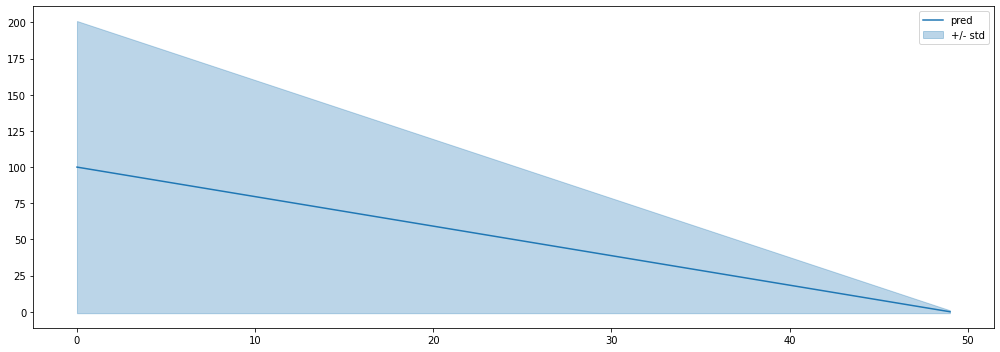

In [3]:
t = np.linspace(0, 100)
y, sigma = t[::-1], 1+t[::-1]
cmapss.plot_rul(pred=y, stddev=sigma, figsize=figsize) 

* The lower quantiles are _constant_!

## Same Stop Chance

**So, we can train for this behavior by minimizing:**

$$
\text{argmax}_\lambda \prod_{i=1}^n \frac{1}{\sigma_i} \phi\left(\frac{f(\hat{x}_i, \lambda) - \hat{y}_i}{\sigma_i}\right)$$

And we will choose $\sigma_i = 1 + \hat{y}_i$. By algebraic manipulation we get:

$$
\text{argmin}_\lambda - \sum_{i=1}^n \log \frac{1}{\sigma_i} - \sum_{i=1}^n \log \phi\left(\frac{f(\hat{x}_i, \lambda) - \hat{y}_i}{\sigma_i}\right) = \\
\text{argmin}_\lambda - \sum_{i=1}^n \log \frac{1}{\sigma_i} - \sum_{i=1}^n \log \frac{1}{\sqrt{2\pi}} - \frac{1}{\sigma_i^2} \left(f(\hat{x}_i, \lambda) - \hat{y}_i\right)^2 = \\
\text{argmin}_\lambda \sum_{i=1}^n \frac{1}{\sigma_i^2} \left(f(\hat{x}_i, \lambda) - \hat{y}_i\right)^2
$$


## Same Stop Chance

**We have just established that:**

$$
\text{argmax}_\lambda \prod_{i=1}^n \frac{1}{\sigma_i} \phi\left(\frac{f(\hat{x}_i, \lambda) - \hat{y}_i}{\sigma_i}\right) =
\text{argmin}_\lambda \sum_{i=1}^n \frac{1}{\sigma_i^2} (f(\hat{x}_i, \lambda) - \hat{y}_i)^2
$$

* I.e. training a normally distributed predictor with per-sample variance $\sigma_i^2$
* Is equivalent to MSE training with _sample weights_ $w_i = 1/\sigma_i^2$

This is suprising simple!


**So, let's define the sample weights**

In [4]:
sample_weight = 1/((1+tr_s['rul'].values)**2)

* We use the rule $\sigma_i = 1 + \hat{y}_i$ to have identical stop chances

## Training

**Let's train our MLP architecture with this modification**

In [5]:
nn1 = build_regressor(hidden=[32, 32])
nn1.compile(optimizer='Adam', loss='mse')
history1 = nn1.fit(tr_s[dt_in], tr_s['rul'], validation_split=0.2,
                 sample_weight=sample_weight,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 2s 1ms/step - loss: 0.0090 - val_loss: 0.0069
Epoch 2/20
1135/1135 [==============================] - 1s 531us/step - loss: 0.0076 - val_loss: 0.0059
Epoch 3/20
1135/1135 [==============================] - 1s 532us/step - loss: 0.0074 - val_loss: 0.0063
Epoch 4/20
1135/1135 [==============================] - 1s 536us/step - loss: 0.0072 - val_loss: 0.0065
Epoch 5/20
1135/1135 [==============================] - 1s 536us/step - loss: 0.0072 - val_loss: 0.0065
Epoch 6/20
1135/1135 [==============================] - 1s 624us/step - loss: 0.0071 - val_loss: 0.0058
Epoch 7/20
1135/1135 [==============================] - 1s 627us/step - loss: 0.0071 - val_loss: 0.0056
Epoch 8/20
1135/1135 [==============================] - 1s 626us/step - loss: 0.0070 - val_loss: 0.0058
Epoch 9/20
1135/1135 [==============================] - 1s 634us/step - loss: 0.0070 - val_loss: 0.0063
Epoch 10/20
1135/1135 [==============================] - 1s 628us/

## Training

**Let's check the loss evolution over time and its final value**

Loss: 0.0068 (training, final), 0.0054 (validation, best)


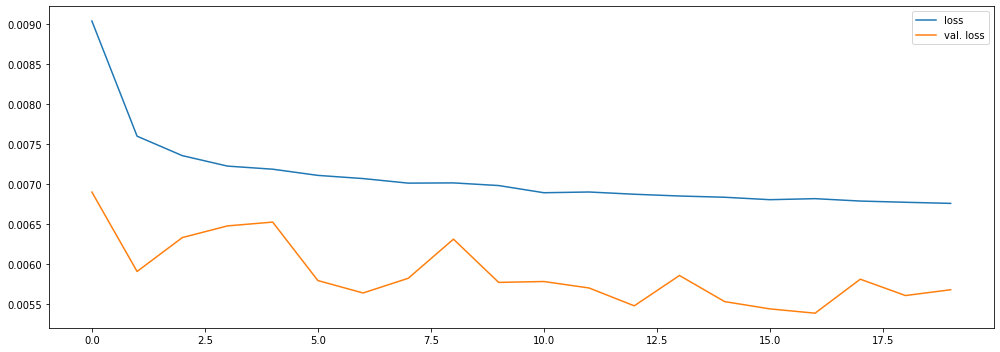

In [6]:
cmapss.plot_training_history(history1, figsize=figsize)
tr1, vl1 = history1.history["loss"][-1], np.min(history1.history["val_loss"])
print(f'Loss: {tr1:.4f} (training, final), {vl1:.4f} (validation, best)')

## Predictions

**The predictions should be (slightly) worse than before in terms of accuracy**

R2 score: 0.5389392096077179


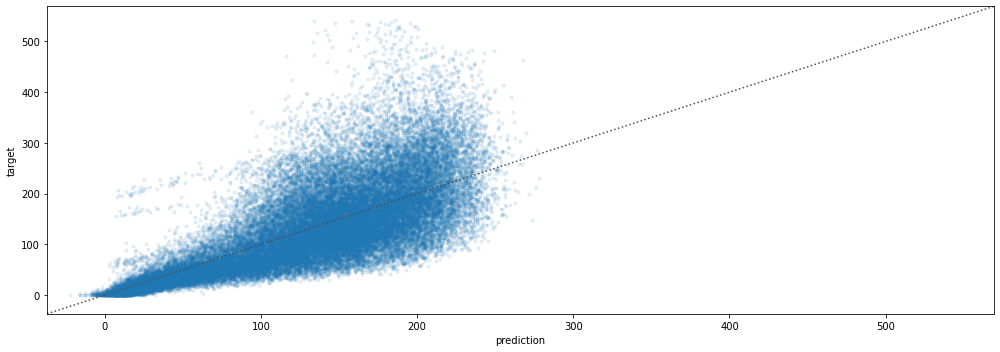

In [7]:
tr_pred1 = nn1.predict(tr_s[dt_in]).ravel() * trmaxrul
cmapss.plot_pred_scatter(tr_pred1, tr['rul'], figsize=figsize)
print(f'R2 score: {r2_score(tr["rul"], tr_pred1)}')

## Predictions

**Let's have a look at the predictions over time (on the training set)**

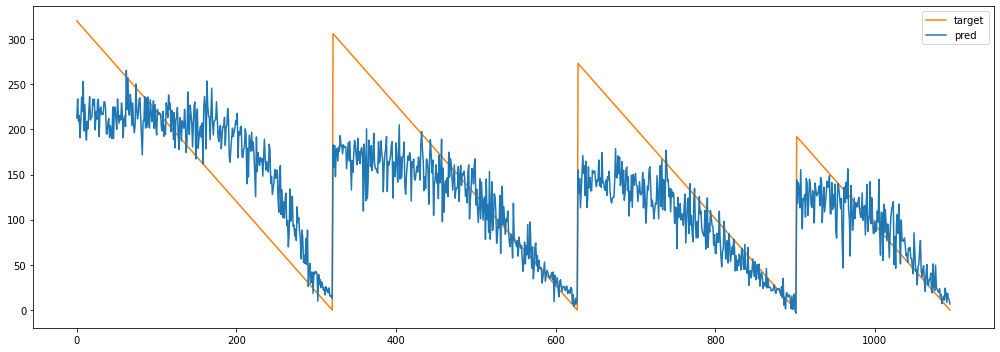

In [10]:
stop = 1095
cmapss.plot_rul(tr_pred1[:stop], tr['rul'][:stop], figsize=figsize)

* Notice how they are noisier in the high-RUL section

## Threshold Optimization

**Now we need to optimize the threshold as usual**

Optimal threshold for the training set: 13


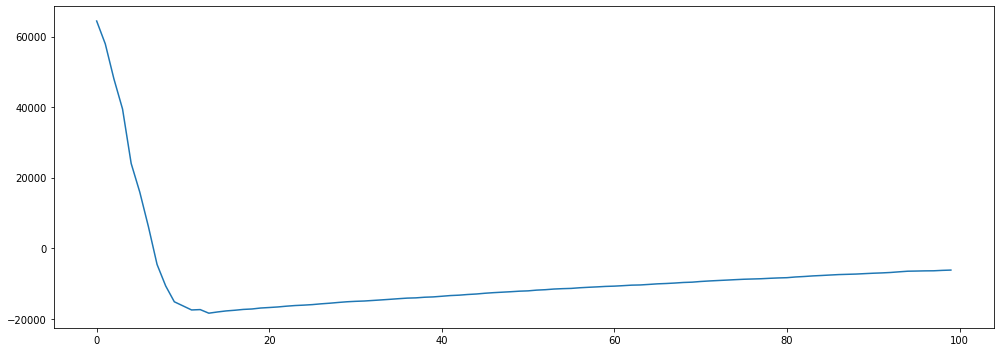

In [11]:
th_range = np.arange(0, 100)
tr_thr1 = cmapss.opt_threshold_and_plot(tr['machine'].values, tr_pred1, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr1}')

## Evaluation

**Let's see how it fares in terms of cost**

In [12]:
ts_pred1 = nn1.predict(ts_s[dt_in]).ravel() * trmaxrul
tr_c1, tr_f1, tr_s1 = cmodel.cost(tr['machine'].values, tr_pred1, tr_thr1, return_margin=True)
ts_c1, ts_f1, ts_s1 = cmodel.cost(ts['machine'].values, ts_pred1, tr_thr1, return_margin=True)
print(f'Cost: {tr_c1} (training), {ts_c1} (test)')
print(f'Avg. fails: {tr_f1/len(tr_mcn)} (training), {ts_f1/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s1/len(tr_mcn):.2f} (training), {ts_s1/len(ts_mcn):.2f} (test)')

Cost: -18425 (training), -6819 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 17.12 (training), 15.57 (test)


* The results should be on par than the MLP
  - ...Depending on training randomness
* The number of fails may be slightly larger
  - Forcing equal stop chances tends to lead to slightly more risky models

We did not gain much, but this is a useful trick to know!

# Negative-Binomial Model

## Negative Binomial Distribution

**The _negative binomial distribution_**

* ...Models the probability to have a number "failures"
* ...Before a given number of "successes" is achieved
* ...Assuming a constant success probability $p$

**It's probability mass function is given by:**

$$
f(k, r, p) = \left(\begin{array}{c}
k+r-1 \\
r-1
\end{array}\right) (1-p)^k p^r
$$

* $k$ is the number of failures
* $r$ is the number of successes
* The binomial coefficient yields the number of combinations of $r-1$ successes
* ...Over $k+r-1$ trials

## RUL and NB Distribution

**There is a connection between the NB distribution and our process**

We can view a "success" as the _end of the run_, a "failure" as an _operating step_

* So, if we assume a constant $p$ for all future steps...
* ...The RUL follows a negative binomial distribution, i.e.:

$$
y \sim \mathit{NB}(1, p)
$$

* The first distribution parameter is $r$
* We have $r = 1$ since after a single "success" the run is over

**We can use a neural model to estimate $p$ based on the observed data, i.e.:**

$$
y \sim \mathit{NB}(1, p(\hat{x}_i, \lambda))
$$

* By doing so, we effectively obtain _a hybrid neural-probabilistic model_

## Training a Neural-Probabilistic Model

**We can train our hybrid model for maximum likelihood**

Or, better, for minimum negative log likelihood:

$$
\text{argmin}_\lambda - \sum_{i=1}^n \log f(\hat{y}_i, 1, p(\hat{x}_i, \lambda))
$$

* Where $f$ is the probability mass function for the NB distribution
* $\hat{y}_i$ is the RUL value (i.e. the number of "failures"...
* ...1 is the number of successes (end of the run)
* ...$p(\hat{x}_i, \lambda)$ is the "success" probability estimated by the neural model

**At inference time:**

* The distribution _mean_ will provide a RUL estimate
* We will be able to access a _variance_, _quantiles_, and _confidence intervals_!


## Building the Probabilistic Model

**We will build the probabilistic model using `tensorflow_probability`**

In particular, we will build a _custom loss function_ for keras:

In [13]:
import tensorflow_probability as tfp
from tensorflow.keras import backend as k

def negbin_likelihood(y_true, y_pred):
    # y_true = RUL, y_pred = probability of going on
    dist = tfp.distributions.NegativeBinomial(total_count=1, logits=y_pred)
    return -k.sum(dist.log_prob(y_true))

* The `NegativeBinomial` class swaps the roles of "success" and "failure"
* In particular, it is designed to work with the "failure" probability (i.e. moving on)
* It supports logit input, in which case a sigmoid is applied to obtain a probability
* ...And it allows the _easy computation of log probabilities_

## Training the Hybrid Model

**We can use our MLP architecture to estimate the NB logit**

In [14]:
nn2 = build_regressor(hidden=[32, 32])
nn2.compile(optimizer='Adam', loss=negbin_likelihood)
history2 = nn2.fit(tr_s[dt_in], tr['rul'].astype(np.float32), validation_split=0.2,
                 callbacks=cb,
                 batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 1s 765us/step - loss: 250.0821 - val_loss: 184.4586
Epoch 2/20
1135/1135 [==============================] - 1s 665us/step - loss: 185.5752 - val_loss: 182.1091
Epoch 3/20
1135/1135 [==============================] - 1s 662us/step - loss: 183.9809 - val_loss: 181.0170
Epoch 4/20
1135/1135 [==============================] - 1s 662us/step - loss: 183.3231 - val_loss: 180.4456
Epoch 5/20
1135/1135 [==============================] - 1s 671us/step - loss: 183.0328 - val_loss: 180.0400
Epoch 6/20
1135/1135 [==============================] - 1s 667us/step - loss: 182.9550 - val_loss: 179.7785
Epoch 7/20
1135/1135 [==============================] - 1s 690us/step - loss: 182.8073 - val_loss: 179.5057
Epoch 8/20
1135/1135 [==============================] - 1s 706us/step - loss: 182.7584 - val_loss: 179.8204
Epoch 9/20
1135/1135 [==============================] - 1s 692us/step - loss: 182.5994 - val_loss: 180.4885
Epoch 10/20
1135/1135 [=====

## Training the Hybrid Model

**Let's check the loss behavior over time**

Loss: 181.9762 (training, final), 178.6933 (validation, best)


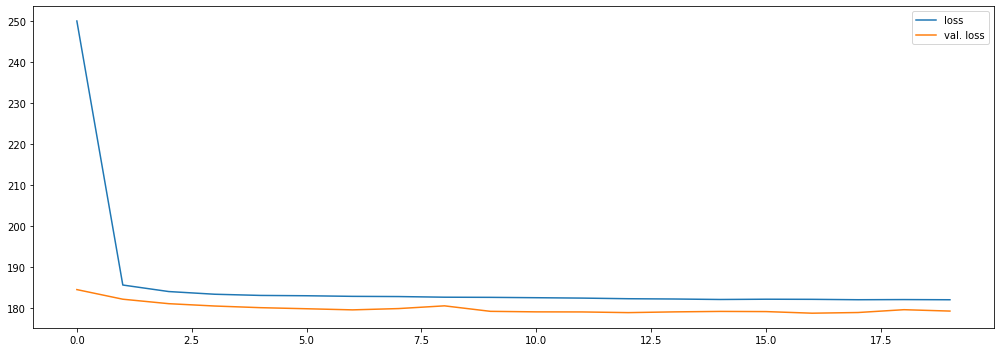

In [15]:
cmapss.plot_training_history(history2, figsize=figsize)
tr2, vl2 = history2.history["loss"][-1], np.min(history2.history["val_loss"])
print(f'Loss: {tr2:.4f} (training, final), {vl2:.4f} (validation, best)')

## Obtaining the Predictions

**The hybrid model prediction corresponds to the _mean_ of the NB distribution**

First, we need to obtain the estimated probabilities:

In [16]:
from scipy.special import expit

tr_logits = nn2.predict(tr_s[dt_in]).ravel()
tr_p = expit(tr_logits)

ts_logits = nn2.predict(ts_s[dt_in]).ravel()
ts_p = expit(ts_logits)

* `expit` is just the sigmoid function (i.e. reverse of logit)

## Obtaining the Predictions

**The hybrid model prediction corresponds to the _mean_ of the NB distribution**

Second, we need to build NB distribution objects

In [17]:
from scipy.stats import nbinom

tr_dist = nbinom(1, 1-tr_p)
ts_dist = nbinom(1, 1-ts_p)

The scipy NB implementation goes by the textbook definition

* Hence, it is parameterized with the probability of a "success"
* ...I.e. the complement of what tensorflow does

That's why we use `1-tr_p` and `1 - ts_p`

## Obtaining the Predictions

**The hybrid model prediction corresponds to the _mean_ of the NB distribution**

Third, we can obtain the means:

In [18]:
tr_pred2 = tr_dist.mean()
ts_pred2 = ts_dist.mean()

But we are not limited to that! We can obtain variances, quantiles, etc.

In [19]:
tr_q1 = tr_dist.ppf(0.25)
tr_q3 = tr_dist.ppf(0.75)
ts_q1 = ts_dist.ppf(0.25)
ts_q3 = ts_dist.ppf(0.75)

## Predictions

**We can plot the predictions _and the 1s/3rd quartiles_**

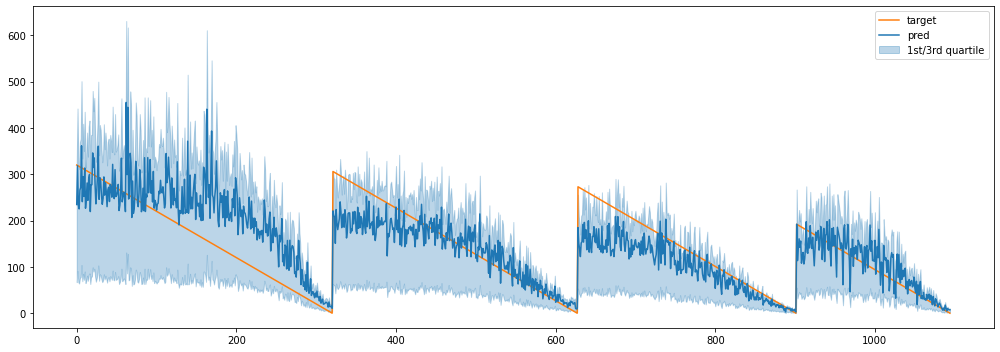

In [20]:
stop = 1095
cmapss.plot_rul(tr_pred2[:stop], tr['rul'][:stop], q1_3=(tr_q1[:stop], tr_q3[:stop]), figsize=figsize)

## Threshold Optimization

**We can perform threshold optimization using _quantiles_**

* E.g. using the 1st quartile we have can choose $\theta$ so that we stop...
* ...Once the estimated probability of $f(\hat{x}_i, \lambda) \geq \theta$ drops below 25%

Optimal threshold for the training set: 4


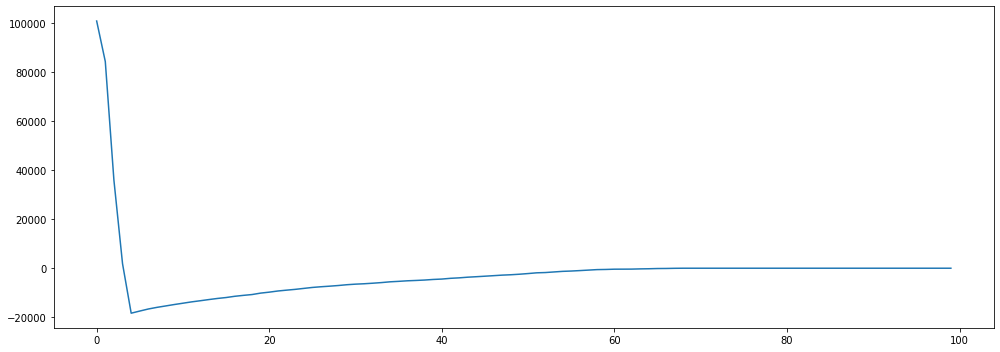

In [21]:
tr_thr2 = cmapss.opt_threshold_and_plot(tr['machine'].values, tr_q1, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr2}')

## Evaluation

**Let's see how it fares in terms of cost**

In [22]:
tr_c2, tr_f2, tr_s2 = cmodel.cost(tr['machine'].values, tr_q1, tr_thr2, return_margin=True)
ts_c2, ts_f2, ts_s2 = cmodel.cost(ts['machine'].values, ts_q1, tr_thr2, return_margin=True)
print(f'Cost: {tr_c2} (training), {ts_c2} (test)')
print(f'Avg. fails: {tr_f2/len(tr_mcn)} (training), {ts_f2/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s2/len(tr_mcn):.2f} (training), {ts_s2/len(ts_mcn):.2f} (test)')

Cost: -18372 (training), -6311 (test)
Avg. fails: 0.0 (training), 0.015873015873015872 (test)
Avg. slack: 17.44 (training), 13.13 (test)


* The results are again on par with the best approaches
* ...But we have a clearer interpretations and confidence intervals!

# Normal Distribution Model

## Normal Distribution Model

**The NB distribution fits naturally our process, but has a few drawbacks**

In particular, the distribution variance is tied to its mean:
$$
\mathit{mean} = \frac{pr}{1-p} \quad\quad \mathit{variance} = \frac{pr}{(1-p)^2}
$$
* We may want to let the model free to adjust its confidence (variance)
* ...Independently on the prediction (mean)

**This can be done via a hybrid neural-probabilistic model**

* We need a distribution with (at least two) parameters (e.g. the Normal one)
* ...And then we need neural models to estimate both. E.g.:
$$
y \sim \mathcal{N}(\mu(\hat{x}, \lambda), \sigma(\hat{x}, \lambda))
$$

## Building the Architecture

**First, we define a function to build the architecture**

In [24]:
def build_probabilistic_regressor(hidden):
    input_shape = (len(dt_in), )
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    mu_logsig = layers.Dense(2, activation='linear')(x)
    lf = lambda t: tfp.distributions.Normal(loc=t[:, :1], scale=k.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    return model

* This time we have chosen to rely on the `DistributionLambda`
  - `DistributionLambda` wraps a probability distribution into a layer
* We pass means and (log) standard deviations in a single tensor
  - Therefore the need to unpack them (i.e. `t[:, :1]` and `t[:, 1:]`)

## Loss Function

**Our loss function will be the negative log likelihood**

How can that be implemented?

* At training time, keras repeatedly "calls" the model
* I.e. it literally invokes the `__call__` method
* For `DistributionLambda`, calling returns a distribution object

**Therefore we can formulate the log likelihood as follows:**

In [25]:
def dlambda_likelihood(y_true, dist):
    return -dist.log_prob(y_true)

* This is very similar to our previous customized loss
* ...Except that we are returning negative log likelihoods for individual examples
* keras will aggregate by default via a sum, _taking into account sample weights_
* Our previous formulation couldn't do this

## Training

**Finally we can train our model**

These type of models often needs to be trained for more epochs

In [33]:
nn3 = build_probabilistic_regressor(hidden=[32, 32])
nn3.compile(optimizer='Adam', loss=dlambda_likelihood)
history3 = nn3.fit(tr_s[dt_in].astype(np.float32), tr_s['rul'].astype(np.float32), validation_split=0.2,
                 batch_size=32, epochs=30, verbose=1)

Epoch 1/30
1135/1135 [==============================] - 1s 766us/step - loss: -0.5254 - val_loss: -0.7733
Epoch 2/30
1135/1135 [==============================] - 1s 683us/step - loss: -0.6871 - val_loss: -0.7841
Epoch 3/30
1135/1135 [==============================] - 1s 674us/step - loss: -0.7334 - val_loss: -0.8779
Epoch 4/30
1135/1135 [==============================] - 1s 673us/step - loss: -0.7525 - val_loss: -0.8806
Epoch 5/30
1135/1135 [==============================] - 1s 673us/step - loss: -0.7785 - val_loss: -0.8649
Epoch 6/30
1135/1135 [==============================] - 1s 679us/step - loss: -0.7939 - val_loss: -0.8961
Epoch 7/30
1135/1135 [==============================] - 1s 676us/step - loss: -0.8075 - val_loss: -0.7821
Epoch 8/30
1135/1135 [==============================] - 1s 679us/step - loss: -0.8132 - val_loss: -0.9175
Epoch 9/30
1135/1135 [==============================] - 1s 684us/step - loss: -0.8310 - val_loss: -0.9577
Epoch 10/30
1135/1135 [=======================

## Obtaining the Predictions

**We are interested both in the predicted mean and standard deviation**

* Therefore, we cannot simply call `predict`
* Instead, we _call the model_ to obtain distribution objects

In [34]:
tr_prob_pred = nn3(tr_s[dt_in].values)
ts_prob_pred = nn3(ts_s[dt_in].values)

**From these, we can obtain means and standard deviations:**

In [35]:
tr_pred3 = tr_prob_pred.mean().numpy().ravel() * trmaxrul
tr_std3 = tr_prob_pred.stddev().numpy().ravel() * trmaxrul
ts_pred3 = ts_prob_pred.mean().numpy().ravel() * trmaxrul
ts_std3 = ts_prob_pred.stddev().numpy().ravel() * trmaxrul

## Predictions

**We can now plot the predictions for the training set**

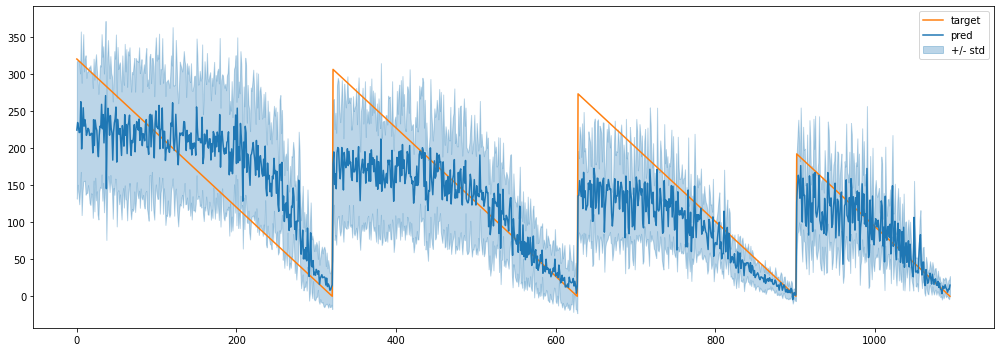

In [36]:
cmapss.plot_rul(tr_pred3[:stop], tr['rul'][:stop], stddev=tr_std3[:stop], figsize=figsize)

## Predictions

**...And for the test set**

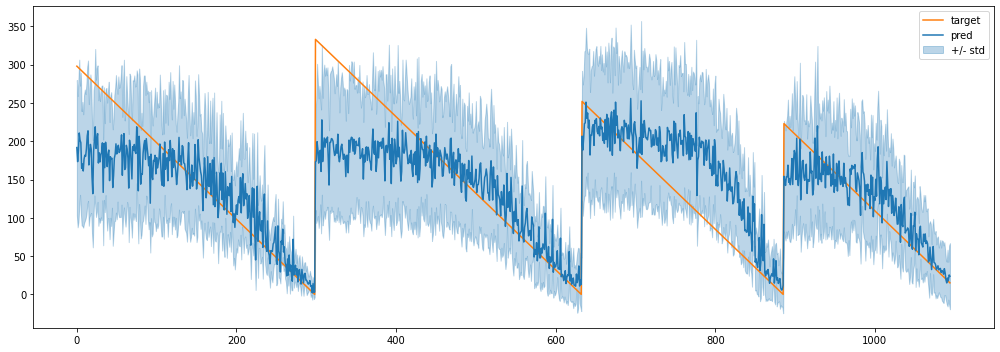

In [37]:
cmapss.plot_rul(ts_pred3[:stop], ts['rul'][:stop], stddev=ts_std3[:stop], figsize=figsize)

## Evaluation

**We can perform threshold optimization and evaluation**

We can use either the means or some quantile

In [38]:
tr_thr3 = cmapss.opt_threshold_and_plot(tr['machine'].values, tr_pred3, th_range, cmodel, plot=False)
print(f'Optimal threshold for the training set: {tr_thr3}')

tr_c3, tr_f3, tr_s3 = cmodel.cost(tr['machine'].values, tr_pred3, tr_thr3, return_margin=True)
ts_c3, ts_f3, ts_s3 = cmodel.cost(ts['machine'].values, ts_pred3, tr_thr3, return_margin=True)
print(f'Cost: {tr_c3} (training), {ts_c3} (test)')
print(f'Avg. fails: {tr_f3/len(tr_mcn)} (training), {ts_f3/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_s3/len(tr_mcn):.2f} (training), {ts_s3/len(ts_mcn):.2f} (test)')

Optimal threshold for the training set: 13
Cost: -17915 (training), -6940 (test)
Avg. fails: 0.005376344086021506 (training), 0.0 (test)
Avg. slack: 16.88 (training), 13.65 (test)


* The results are once again on par with the best approaches
* As in the previous case, we have a clearer interpretation...
* ...But also more flexible confidence intervals!

## Considerations

**Why going for hybrid probabilistic models?**

* They are typically harder to train than traditional ML models
* ...But the provide confidence _quantiles and standard deviations_!
* _Never_ underestimate how useful a confidence interval can be

**Probabilistic models enable reasoning**

* We can _choose thresholds based on probabilistic considerations_
  - E.g. I want the estimated chance that RUL <= 1 to be lower than 0.10
  - This is _very handy when data is scarce_
  - ...And cost optimization becomes therefore impossible
* It is possible to define probabilistic _cost_ models
  - E.g. expected financial cost of maintenance policy
  - They are often the key to build end-to-end cost optimization approaches